In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency, kruskal

from SSNHL.util import load_data

In [2]:
raw_data = load_data('../raw_data/all.xlsx', preprocess_func=None)
raw_data = raw_data.drop(
    ("coagulation function", "fibrinogen", "after treatment"), axis=1
)
raw_data = raw_data.drop(
    ("blood lipids", "Unnamed: 17_level_1", "triglycerides"), axis=1
)
raw_data = raw_data.drop(
    ("treatment plan", "Unnamed: 27_level_1", "tympanic injection time"), axis=1
)
raw_data.columns = ['-'.join([item for item in col if 'Unnamed' not in item]) for col in raw_data.columns.values]

raw_data = raw_data[~raw_data['efficacy evaluation'].isna()]
raw_data

/Users/liminghong/Library/Mobile Documents/com~apple~CloudDocs/Documents/workspace/python/SSNHL/SSNHL/util.py:14: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = data.drop(["note"], axis=1)


,sex,age,ear,time of onset,symptom-vertigo,symptom-ear blockage,symptom-tinnitus,past medical history-hypertension,past medical history-diabetes,past medical history-tinnitus,...,pure tone analysis-left-mean hearing threshold,pure tone analysis-left-curve type,pure tone analysis-left-grade,pure tone analysis-right-mean hearing threshold,pure tone analysis-right-curve type,pure tone analysis-right-grade,revive,ABR,otoacoustic emission (500-6000Hz),efficacy evaluation
1,1,63,R,0,0,1,1,1,0,0,...,44.0,-,-,28,1,1,1,0,1,3.0
2,0,27,L,0,0,1,0,0,0,0,...,18.0,1,0,9,0,0,1,-,-,3.0
3,0,54,L,0,0,1,1,0,0,0,...,41.0,3,2,11,0,0,1,0,-,3.0
4,1,33,L,2,0,0,1,0,0,0,...,19.0,1,0,13,0,0,0,0,-,3.0
5,0,50,L,0,0,1,0,0,0,0,...,8.0,1,0,5,0,0,0,0,-,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0,66,L,2,0,0,0,0,0,0,...,110.0,4,6,18,0,0,0,1,1,1.0
605,1,36,L,0,1,1,1,0,0,0,...,89.0,4,5,11,0,0,0,1,1,1.0
606,0,62,L,0,1,1,1,0,0,0,...,NaN,4,6,31,2,1,0,1,1,1.0
607,1,65,L,1,1,0,1,0,0,0,...,108.0,4,6,35,2,1,0,1,1,1.0


,column_name,nan_count,dash_count,conceptually_vague_count,fill_count
0,sex,0,0,0,0
1,age,0,0,0,0
2,ear,0,0,0,0
3,time of onset,0,0,0,0
4,symptom-vertigo,0,0,0,0
5,symptom-ear blockage,0,0,0,0
6,symptom-tinnitus,0,0,0,0
7,past medical history-hypertension,0,0,0,0
8,past medical history-diabetes,0,0,0,0
9,past medical history-tinnitus,0,0,0,0


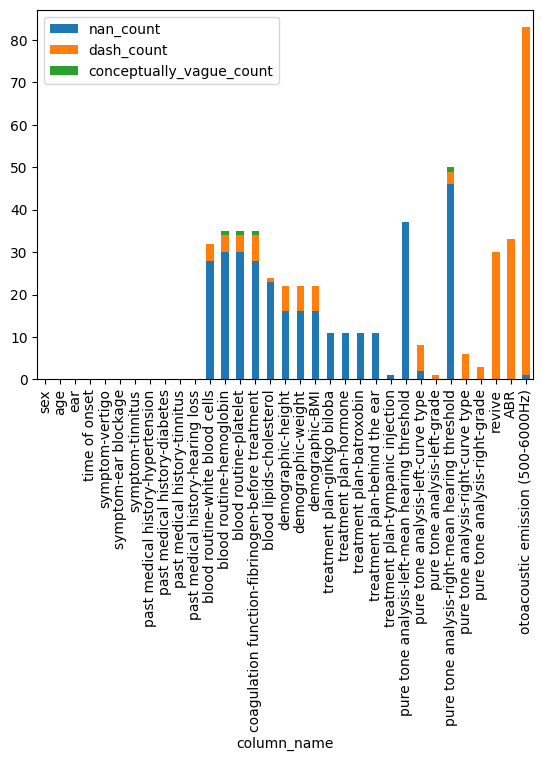

In [3]:
column_counts = pd.DataFrame(columns=['column_name', 'nan_count', 'dash_count', 'conceptually_vague_count', 'fill_count'])
for column in raw_data.columns.drop(['efficacy evaluation']):
    nan_count = raw_data[column].isna().sum()
    dash_count = (raw_data[column] == '-').sum()
    normal_count = (raw_data[column] == 'normal').sum()

    column_counts.loc[len(column_counts)] = [column, nan_count, dash_count, normal_count, nan_count+dash_count+normal_count]

fig = column_counts.plot.bar(x='column_name', y=['nan_count', 'dash_count', 'conceptually_vague_count'], stacked=True).get_figure()
fig.savefig('../output/distribution/missing_count.pdf', bbox_inches="tight")
column_counts

In [4]:
data = raw_data.copy()
data = data.fillna('-')
data.replace('normal', '-', inplace=True)

data.loc[data['efficacy evaluation'] == 0, 'efficacy evaluation'] = 'ineffective'
data.loc[data['efficacy evaluation'] == 1, 'efficacy evaluation'] = 'effective'
data.loc[data['efficacy evaluation'] == 2, 'efficacy evaluation'] = 'markedly effective'
data.loc[data['efficacy evaluation'] == 3, 'efficacy evaluation'] = 'cured'
data['efficacy evaluation'] = pd.Categorical(data['efficacy evaluation'], ['ineffective', 'effective', 'markedly effective', 'cured'])

data

,sex,age,ear,time of onset,symptom-vertigo,symptom-ear blockage,symptom-tinnitus,past medical history-hypertension,past medical history-diabetes,past medical history-tinnitus,...,pure tone analysis-left-mean hearing threshold,pure tone analysis-left-curve type,pure tone analysis-left-grade,pure tone analysis-right-mean hearing threshold,pure tone analysis-right-curve type,pure tone analysis-right-grade,revive,ABR,otoacoustic emission (500-6000Hz),efficacy evaluation
1,1,63,R,0,0,1,1,1,0,0,...,44.0,-,-,28,1,1,1,0,1,cured
2,0,27,L,0,0,1,0,0,0,0,...,18.0,1,0,9,0,0,1,-,-,cured
3,0,54,L,0,0,1,1,0,0,0,...,41.0,3,2,11,0,0,1,0,-,cured
4,1,33,L,2,0,0,1,0,0,0,...,19.0,1,0,13,0,0,0,0,-,cured
5,0,50,L,0,0,1,0,0,0,0,...,8.0,1,0,5,0,0,0,0,-,cured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,0,66,L,2,0,0,0,0,0,0,...,110.0,4,6,18,0,0,0,1,1,effective
605,1,36,L,0,1,1,1,0,0,0,...,89.0,4,5,11,0,0,0,1,1,effective
606,0,62,L,0,1,1,1,0,0,0,...,-,4,6,31,2,1,0,1,1,effective
607,1,65,L,1,1,0,1,0,0,0,...,108.0,4,6,35,2,1,0,1,1,effective


In [5]:
discrete_value_columns = data.columns[data.nunique() < 10].drop('efficacy evaluation')
consecutive_value_columns = data.columns[data.nunique() >= 10]

In [6]:
df = pd.DataFrame()
for column in discrete_value_columns:
    _data = data[data[column] != '-']

    _df = pd.crosstab(_data[column], _data['efficacy evaluation'], rownames=['value']).reset_index()

    stat, p, dof, expected =  chi2_contingency(_df[_df.columns.drop('value')])
    _df['P'] = p

    _df['feature'] = column
    _df.set_index(['feature', 'value'], inplace=True)
    df = pd.concat([df, _df])
df.to_csv('../output/distribution/discrete_feature_distribution.csv')
df

efficacy evaluation                      ineffective  effective  \
feature                           value                           
sex                               0              159         42   
                                  1              151         35   
ear                               L              156         32   
                                  L/R              5          1   
                                  R              149         44   
...                                              ...        ...   
revive                            1              101         19   
ABR                               0              153         31   
                                  1              139         44   
otoacoustic emission (500-6000Hz) 0               62         14   
                                  1              201         52   

efficacy evaluation                      markedly effective  cured  \
feature                           value                              
sex                               0                      41     81   
                                  1                      53     46   
ear                               L                      46     70   
                                  L/R                     1      0   
                                  R                      47     57   
...                                                     ...    ...   
revive                            1                       9     56   
ABR                               0                      26    113   
                                  1                      63      6   
otoacoustic emission (500-6000Hz) 0                       6     85   
                                  1                      77     28   

efficacy evaluation                                 P  
feature                           value                
sex                               0      2.145996e-02  
                                  1      2.145996e-02  
ear                               L      4.929953e-01  
                                  L/R    4.929953e-01  
                                  R      4.929953e-01  
...                                               ...  
revive                            1      2.197660e-07  
ABR                               0      4.005042e-23  
                                  1      4.005042e-23  
otoacoustic emission (500-6000Hz) 0      1.258908e-28  
                                  1      1.258908e-28  

[62 rows x 5 columns]

In [7]:
df = pd.DataFrame()
for column in consecutive_value_columns:
    _data = data[data[column] != '-']

    _df = {}
    column_values = []
    for efficacy in _data['efficacy evaluation'].cat.categories:
        _column_values = _data.loc[_data['efficacy evaluation'] == efficacy, column]
        _df[efficacy] = '{}({}-{})'.format(round(_column_values.median(), 2), _column_values.min(), _column_values.max())
        column_values.append(_column_values)
    _df = pd.DataFrame([_df])

    stat, p = kruskal(*column_values)
    _df['P'] = p

    _df['feature'] = column
    _df.set_index('feature', inplace=True)
    df = pd.concat([df, _df])
df.to_csv('../output/distribution/consecutive_feature_distribution.csv')
df

,ineffective,effective,markedly effective,cured,P
feature,,,,,
age,50.0(18-84),47.0(18-84),51.0(19-81),38.0(18-75),7.432412e-09
blood routine-white blood cells,8.41(2.79-22.16),8.77(3.77-18.33),8.57(3.21-22.14),8.41(3.37-19.29),5.431596e-01
blood routine-hemoglobin,136.0(50-172),140.0(78-177),139.5(89-178),136.0(76-180),6.510602e-01
blood routine-platelet,246.5(136-545),262.5(97-391),251.0(57-548),263.0(152-1117),3.808950e-01
coagulation function-fibrinogen-before treatment,2.61(0.46-8.18),2.48(1-4.87),2.55(0.52-5.22),2.37(0.56-4.62),2.777832e-02
blood lipids-cholesterol,5.16(2.47-8.88),5.3(3.54-9.1),5.18(3.3-8.59),4.94(3.4-7.48),4.758982e-02
demographic-height,1.62(1.41-1.85),1.62(1.43-1.86),1.65(1.41-1.82),1.61(1.42-1.82),4.484336e-01
demographic-weight,61.7(30.4-99.9),58.2(33.1-94.1),61.0(26.3-113),59.3(39.1-105.7),4.694866e-01
demographic-BMI,23.4(12.8-33.8),22.8(16.1-31.5),23.4(16.2-68.1),22.35(15.5-36),4.502552e-02


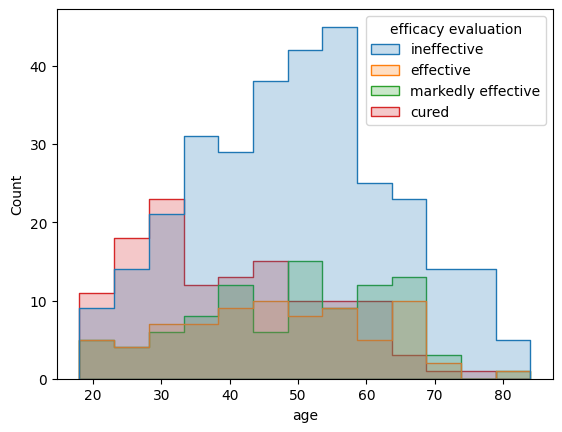

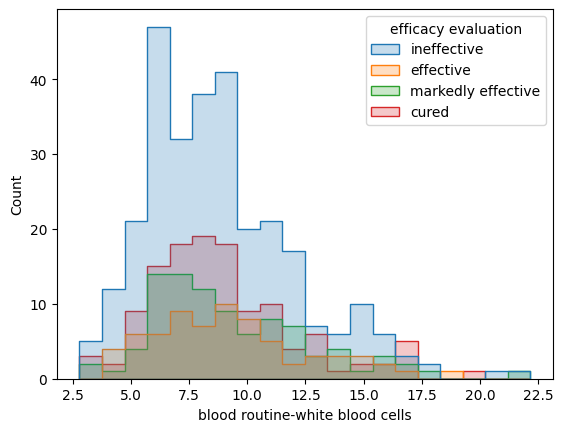

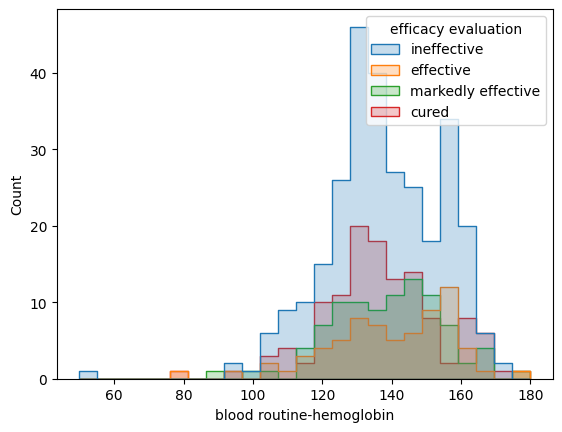

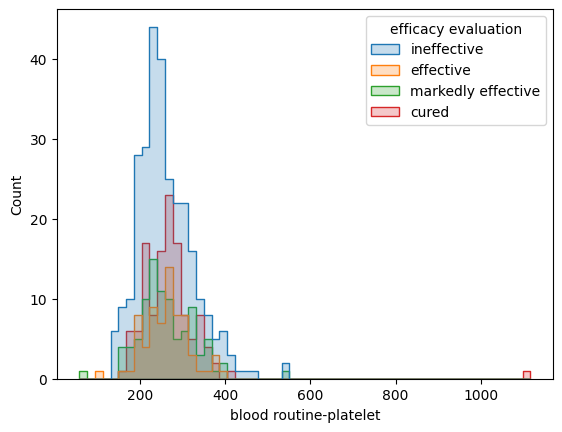

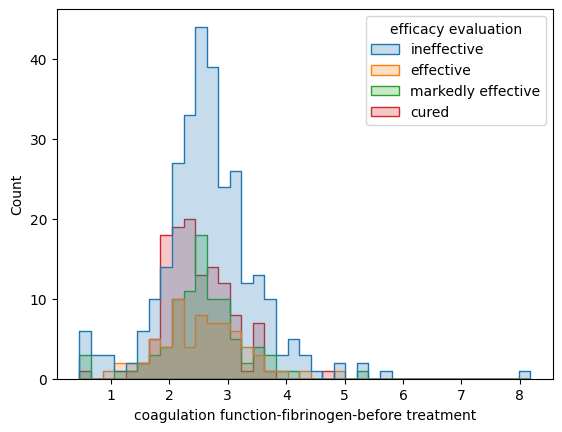

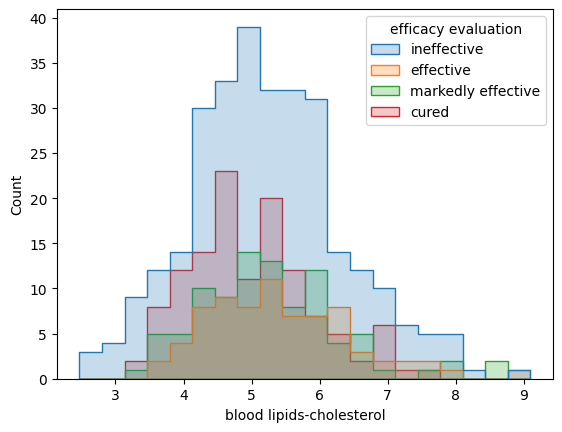

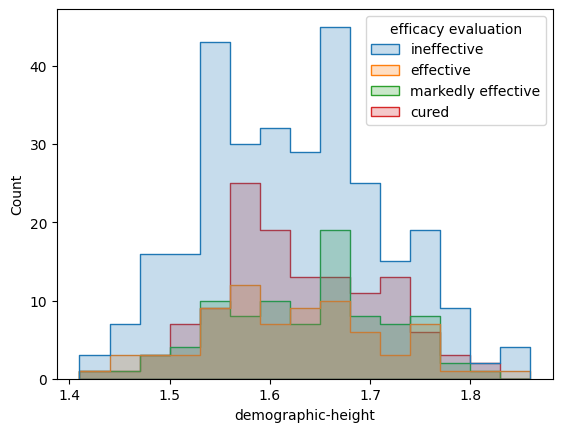

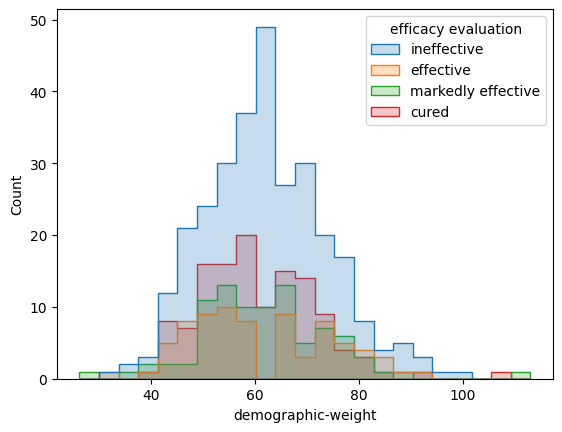

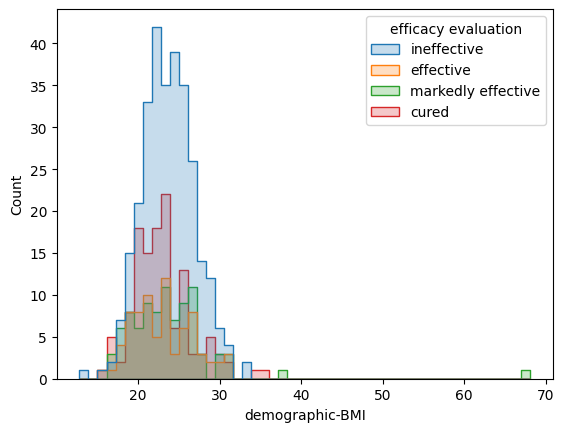

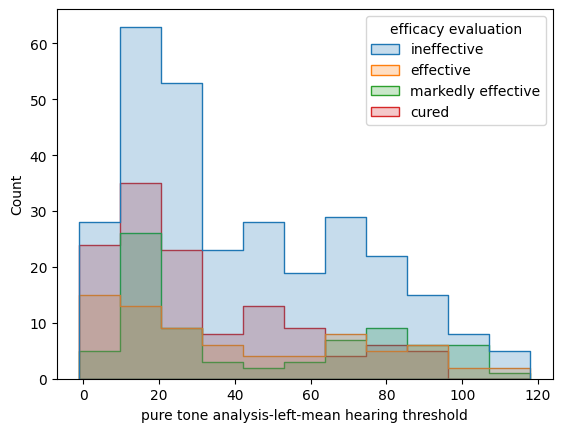

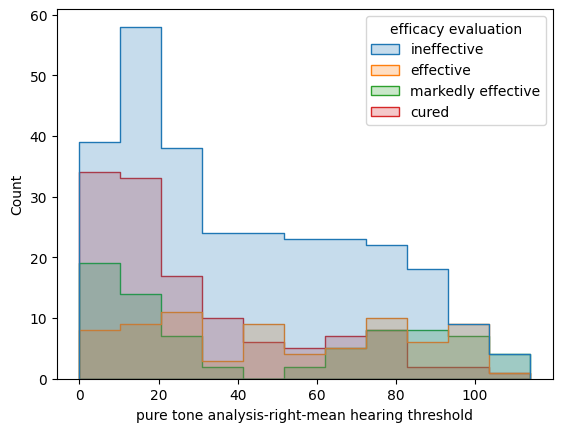

In [8]:
for column in consecutive_value_columns:
    _data = data[data[column] != '-']

    sns.histplot(data=_data, x=column, hue='efficacy evaluation', element="step")
    plt.savefig('../output/distribution/{}.pdf'.format(column), bbox_inches="tight")
    plt.show()

In [9]:
df = pd.DataFrame()
for column in data.columns.drop('efficacy evaluation'):
    _data = data[[column, 'efficacy evaluation']][data[column] == '-']

    _df = pd.crosstab(_data[column], _data['efficacy evaluation'], rownames=['feature']).reset_index()
    _df['feature'] = column
    _df.set_index('feature', inplace=True)
    df = pd.concat([df, _df])
df = df.fillna(0).astype(int)
df.to_csv('../output/distribution/missing_distribution.csv')
df

efficacy evaluation,ineffective,effective,markedly effective,cured
feature,,,,
blood routine-white blood cells,20,7,2,3
blood routine-hemoglobin,22,7,2,4
blood routine-platelet,22,7,2,4
coagulation function-fibrinogen-before treatment,19,8,4,4
blood lipids-cholesterol,17,2,2,3
demographic-height,15,1,5,1
demographic-weight,15,1,5,1
demographic-BMI,15,1,5,1
treatment plan-ginkgo biloba,9,0,1,1
